In [1]:
# Import
import torch
import numpy as np
import pandas as pd
import kagglehub
import os
import tqdm
import cv2

from glob import glob
from matplotlib import pyplot as plt
from PIL import Image

In [2]:
!pip -q install kagglehub[pandas-datasets]
print("📥 Téléchargement du dataset...")
dataset_path = kagglehub.dataset_download("shafiullahshafin/c-nmc-2019-dataset")

print(f"✅ Dataset téléchargé ici : {dataset_path}")

def build_dataframe(base_path):
    data = []
    image_paths = glob(os.path.join(base_path, '**', '*.bmp'), recursive=True)

    print(f"🔍 Images trouvées : {len(image_paths)}")

    for img_path in image_paths:
        folder_name = os.path.basename(os.path.dirname(img_path))

        if 'all' in folder_name.lower():
            label = 'ALL'
        elif 'hem' in folder_name.lower():
            label = 'HEM' # Normal
        else:
            continue

        data.append({
            'image_path': img_path,
            'label': label,
            'filename': os.path.basename(img_path)
        })

    return pd.DataFrame(data)

df = build_dataframe(dataset_path)

print(f"\n📊 DataFrame construit avec {len(df)} images.")
print(df.head())

📥 Téléchargement du dataset...
Using Colab cache for faster access to the 'c-nmc-2019-dataset' dataset.
✅ Dataset téléchargé ici : /kaggle/input/c-nmc-2019-dataset
🔍 Images trouvées : 15114

📊 DataFrame construit avec 10661 images.
                                          image_path label  \
0  /kaggle/input/c-nmc-2019-dataset/C-NMC 2019 (P...   ALL   
1  /kaggle/input/c-nmc-2019-dataset/C-NMC 2019 (P...   ALL   
2  /kaggle/input/c-nmc-2019-dataset/C-NMC 2019 (P...   ALL   
3  /kaggle/input/c-nmc-2019-dataset/C-NMC 2019 (P...   ALL   
4  /kaggle/input/c-nmc-2019-dataset/C-NMC 2019 (P...   ALL   

              filename  
0   UID_28_5_3_all.bmp  
1  UID_45_24_5_all.bmp  
2   UID_45_7_1_all.bmp  
3  UID_52_10_5_all.bmp  
4  UID_52_21_7_all.bmp  


In [3]:
df = pd.read_csv("df.csv")
df.head(3)

,image_path,label,filename
0,/root/.cache/kagglehub/datasets/shafiullahshaf...,HEM,UID_H22_21_6_hem.bmp
1,/root/.cache/kagglehub/datasets/shafiullahshaf...,HEM,UID_H14_22_3_hem.bmp
2,/root/.cache/kagglehub/datasets/shafiullahshaf...,HEM,UID_H10_172_3_hem.bmp


## Baseline

Create a baseline test to compare preprocessings


### Dataset

In [4]:
from dataclasses import dataclass

@dataclass
class Config:
  seed: int = 42
  batch_size: int = 32
  lr : float = 1e-4
  epoch: int = 10
  train_split: float = 0.8
  dropout: float = 0.5

  @property
  def test_split(self):
    return round((1 - self.train_split) / 2, 2)

  @property
  def validation_split(self):
    return self.test_split

  @property
  def device(self):
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")


config = Config()

In [5]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

class LeukomiaDataset(Dataset):
    def __init__(self, df, transform=None):
      super().__init__()
      self.label_map = {"HEM": 0, "ALL": 1}

      self.X = df['image_path'].values
      self.y = df['label'].map(self.label_map).values
      self.transform = transform

      if transform is None:
        self.transform = transforms.Compose([
          transforms.Resize((224, 224)),
          transforms.RandomHorizontalFlip(p=0.5),
          transforms.RandomRotation(15),
          transforms.ToTensor(),
          transforms.ColorJitter(
              brightness=0.2,
              contrast=0.2,
              saturation=0.1,
          ),
          transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
          transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
      return len(self.X)

    def __getitem__(self, idx):
      img = Image.open(self.X[idx]).convert('RGB')
      label = torch.tensor(self.y[idx], dtype=torch.long)

      if self.transform:
        img = self.transform(img)

      return img, label


leukomia_dataset = LeukomiaDataset(df)
sample_X, sample_y = next(iter(leukomia_dataset))
sample_X.shape, sample_y

(torch.Size([3, 224, 224]), tensor(0))

In [6]:
len_train_data = int(len(df) * config.train_split)
len_validation_data = int(len(df) * config.validation_split)
len_test_data = int(len(df) * config.test_split)

df_shuffled = df.sample(frac=1, random_state=config.seed).reset_index(drop=True)
df_train = df_shuffled[:len_train_data][:]
df_validation = df_shuffled[len_train_data:len_train_data+len_validation_data][:]
df_test = df_shuffled[len_train_data+len_validation_data:][:]

df_train.shape, df_validation.shape, df_test.shape

((8528, 3), (1066, 3), (1067, 3))

In [7]:
train_dataset = LeukomiaDataset(df_train)
validation_dataset = LeukomiaDataset(df_validation)
test_dataset = LeukomiaDataset(df_test)


def get_dataloader(dataset, shuffle=False):
  return DataLoader(dataset,
                    batch_size=config.batch_size,
                    shuffle=shuffle,
                    num_workers=2,
                    pin_memory=True,
                    drop_last=shuffle,
                    persistent_workers=True,
                    prefetch_factor=2,
        )

train_dataloader = get_dataloader(train_dataset, shuffle=True)
validation_dataloader = get_dataloader(validation_dataset)
test_dataloader = get_dataloader(test_dataset)

img_tensor, y_tensor = next(iter(train_dataloader))
img_tensor.shape, y_tensor.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

### Baseline model


 #### Reset18

In [8]:
import torch

config = Config(lr=1e-4, epoch=10, dropout=0.3)

model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
# model.fc = torch.nn.Linear(model.fc.in_features, 2)
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(config.dropout),
    torch.nn.Linear(model.fc.in_features, 2)
)

model = model.to(config.device)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:

optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr)
criterion = torch.nn.CrossEntropyLoss()

train_losses = []
validation_losses = []

def train_model(model, config):
    for epoch in tqdm.tqdm(range(config.epoch)):
        model.train()
        epoch_train_loss = 0

        for image_tensor, label in train_dataloader:
            img_tensor = image_tensor.to(config.device)
            label = label.to(config.device)

            optimizer.zero_grad()

            output = model(img_tensor)
            loss = criterion(output, label)

            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()

        train_losses.append(epoch_train_loss / len(train_dataloader))

        model.eval()
        epoch_val_loss = 0

        for image_tensor, label in validation_dataloader:
            img_tensor = image_tensor.to(config.device)
            label = label.to(config.device)

            with torch.no_grad():
                output = model(img_tensor)
                loss = criterion(output, label)
                epoch_val_loss += loss.item()


        validation_losses.append(epoch_val_loss / len(validation_dataloader))


        print(f" Epoch {epoch+1}/{config.epoch} - " \
              f"Train Loss: {train_losses[-1]:.4f} - " \
              f"Val Loss: {validation_losses[-1]:.4f}")

    return model

model_resnet18 = train_model(model, config)



 10%|█         | 1/10 [00:41<06:14, 41.65s/it]

 Epoch 1/10 - Train Loss: 0.3840 - Val Loss: 0.2622


 20%|██        | 2/10 [01:22<05:31, 41.43s/it]

 Epoch 2/10 - Train Loss: 0.2755 - Val Loss: 0.2754


 30%|███       | 3/10 [02:03<04:47, 41.09s/it]

 Epoch 3/10 - Train Loss: 0.2289 - Val Loss: 0.2479


 40%|████      | 4/10 [02:42<04:02, 40.37s/it]

 Epoch 4/10 - Train Loss: 0.2080 - Val Loss: 0.1713


 50%|█████     | 5/10 [03:22<03:20, 40.00s/it]

 Epoch 5/10 - Train Loss: 0.1900 - Val Loss: 0.2381


 60%|██████    | 6/10 [04:02<02:40, 40.09s/it]

 Epoch 6/10 - Train Loss: 0.1695 - Val Loss: 0.2742


 70%|███████   | 7/10 [04:42<02:00, 40.19s/it]

 Epoch 7/10 - Train Loss: 0.1495 - Val Loss: 0.1476


 80%|████████  | 8/10 [05:23<01:20, 40.23s/it]

 Epoch 8/10 - Train Loss: 0.1523 - Val Loss: 0.1318


 90%|█████████ | 9/10 [06:03<00:40, 40.33s/it]

 Epoch 9/10 - Train Loss: 0.1444 - Val Loss: 0.1333


100%|██████████| 10/10 [06:44<00:00, 40.41s/it]

 Epoch 10/10 - Train Loss: 0.1206 - Val Loss: 0.1975


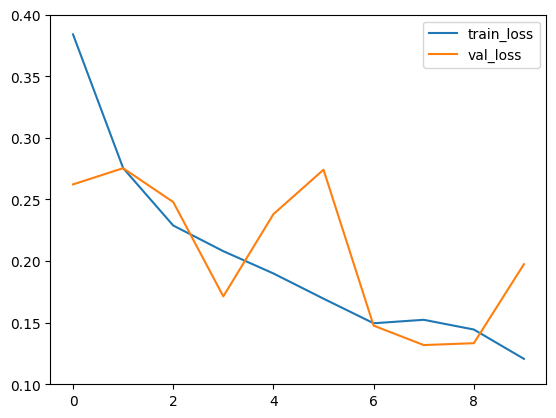

In [10]:
plt.plot(np.arange(config.epoch), train_losses, label='train_loss')
plt.plot(np.arange(config.epoch), validation_losses, label='val_loss')
plt.legend()
plt.yticks(np.arange(0.1, max(train_losses + validation_losses) + 0.05, 0.05))
plt.show()

#### Resnet50

In [11]:
config = Config(lr=1e-4, epoch=30, dropout=0.2)

model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
# model.fc = torch.nn.Linear(model.fc.in_features, 2)

for param in model.parameters():
    param.requires_grad = False

for name, param in model.named_parameters():
    if 'layer4' in name or 'fc' in name:
        param.requires_grad = True

model.fc = torch.nn.Sequential(
    torch.nn.Dropout(config.dropout),
    torch.nn.Linear(model.fc.in_features, 2)
)

model = model.to(config.device)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=config.lr, weight_decay=0.05)
criterion = torch.nn.CrossEntropyLoss()

train_losses = []
validation_losses = []

model_resnet50 = train_model(model, config)

  3%|▎         | 1/30 [00:40<19:29, 40.31s/it]

 Epoch 1/30 - Train Loss: 0.4068 - Val Loss: 0.3942


  7%|▋         | 2/30 [01:20<18:51, 40.42s/it]

 Epoch 2/30 - Train Loss: 0.3422 - Val Loss: 0.3373


 10%|█         | 3/30 [02:01<18:13, 40.50s/it]

 Epoch 3/30 - Train Loss: 0.3322 - Val Loss: 0.3361


 13%|█▎        | 4/30 [02:42<17:35, 40.60s/it]

 Epoch 4/30 - Train Loss: 0.3160 - Val Loss: 0.3845


 17%|█▋        | 5/30 [03:22<16:56, 40.65s/it]

 Epoch 5/30 - Train Loss: 0.3166 - Val Loss: 0.3125


 20%|██        | 6/30 [04:03<16:16, 40.69s/it]

 Epoch 6/30 - Train Loss: 0.3128 - Val Loss: 0.3141


 23%|██▎       | 7/30 [04:44<15:36, 40.72s/it]

 Epoch 7/30 - Train Loss: 0.3021 - Val Loss: 0.2874


 27%|██▋       | 8/30 [05:24<14:54, 40.67s/it]

 Epoch 8/30 - Train Loss: 0.2894 - Val Loss: 0.3297


 30%|███       | 9/30 [06:05<14:13, 40.64s/it]

 Epoch 9/30 - Train Loss: 0.2882 - Val Loss: 0.2694


 33%|███▎      | 10/30 [06:45<13:31, 40.55s/it]

 Epoch 10/30 - Train Loss: 0.2870 - Val Loss: 0.3200


 37%|███▋      | 11/30 [07:26<12:48, 40.45s/it]

 Epoch 11/30 - Train Loss: 0.2842 - Val Loss: 0.2630


 40%|████      | 12/30 [08:06<12:08, 40.49s/it]

 Epoch 12/30 - Train Loss: 0.2730 - Val Loss: 0.2832


 43%|████▎     | 13/30 [08:47<11:29, 40.59s/it]

 Epoch 13/30 - Train Loss: 0.2654 - Val Loss: 0.3673


 47%|████▋     | 14/30 [09:28<10:49, 40.61s/it]

 Epoch 14/30 - Train Loss: 0.2601 - Val Loss: 0.2478


 50%|█████     | 15/30 [10:08<10:08, 40.59s/it]

 Epoch 15/30 - Train Loss: 0.2585 - Val Loss: 0.2550


 53%|█████▎    | 16/30 [10:49<09:28, 40.58s/it]

 Epoch 16/30 - Train Loss: 0.2480 - Val Loss: 0.2873


 57%|█████▋    | 17/30 [11:29<08:47, 40.59s/it]

 Epoch 17/30 - Train Loss: 0.2510 - Val Loss: 0.2595


 60%|██████    | 18/30 [12:10<08:07, 40.62s/it]

 Epoch 18/30 - Train Loss: 0.2484 - Val Loss: 0.2853


 63%|██████▎   | 19/30 [12:51<07:26, 40.60s/it]

 Epoch 19/30 - Train Loss: 0.2442 - Val Loss: 0.2548


 67%|██████▋   | 20/30 [13:31<06:46, 40.63s/it]

 Epoch 20/30 - Train Loss: 0.2470 - Val Loss: 0.2524


 70%|███████   | 21/30 [14:12<06:05, 40.56s/it]

 Epoch 21/30 - Train Loss: 0.2398 - Val Loss: 0.2729


 73%|███████▎  | 22/30 [14:52<05:23, 40.47s/it]

 Epoch 22/30 - Train Loss: 0.2332 - Val Loss: 0.2557


 77%|███████▋  | 23/30 [15:33<04:43, 40.55s/it]

 Epoch 23/30 - Train Loss: 0.2347 - Val Loss: 0.2659


 80%|████████  | 24/30 [16:14<04:03, 40.67s/it]

 Epoch 24/30 - Train Loss: 0.2360 - Val Loss: 0.2460


 83%|████████▎ | 25/30 [16:55<03:23, 40.75s/it]

 Epoch 25/30 - Train Loss: 0.2263 - Val Loss: 0.3054


 87%|████████▋ | 26/30 [17:35<02:42, 40.74s/it]

 Epoch 26/30 - Train Loss: 0.2281 - Val Loss: 0.2612


 90%|█████████ | 27/30 [18:17<02:02, 40.87s/it]

 Epoch 27/30 - Train Loss: 0.2296 - Val Loss: 0.2698


 93%|█████████▎| 28/30 [18:58<01:21, 40.92s/it]

 Epoch 28/30 - Train Loss: 0.2357 - Val Loss: 0.2657


 97%|█████████▋| 29/30 [19:38<00:40, 40.83s/it]

 Epoch 29/30 - Train Loss: 0.2315 - Val Loss: 0.2067


100%|██████████| 30/30 [20:19<00:00, 40.65s/it]

 Epoch 30/30 - Train Loss: 0.2219 - Val Loss: 0.2341


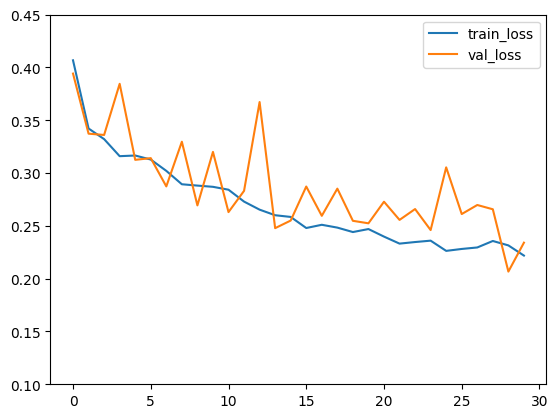

In [13]:
plt.plot(np.arange(config.epoch), train_losses, label='train_loss')
plt.plot(np.arange(config.epoch), validation_losses, label='val_loss')
plt.legend()
plt.yticks(np.arange(0.1, max(train_losses + validation_losses) + 0.05, 0.05))
plt.show()

In [14]:
!pip install torchmetrics

------------------------------
Accuracy : 0.9072
Recall   : 0.9320 (Sensibilité)
Precision: 0.9307
F1 Score : 0.9314
------------------------------


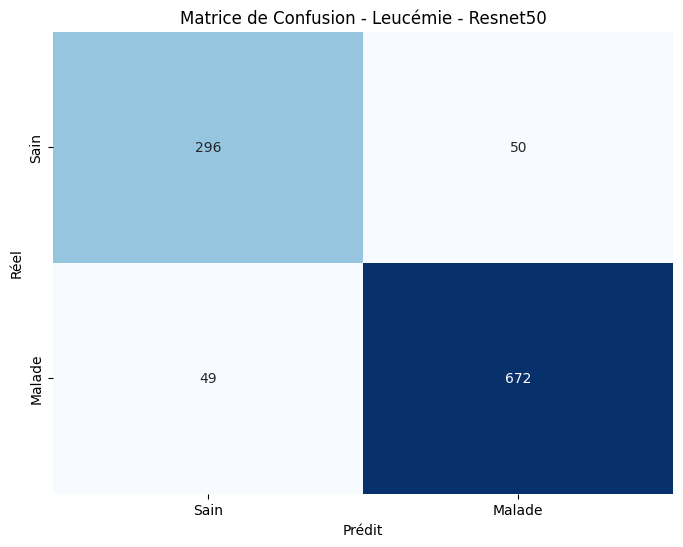

In [15]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from torchmetrics.classification import BinaryAccuracy, BinaryRecall, BinaryPrecision, BinaryF1Score, BinaryConfusionMatrix

def test_model(model, dataloader, device):
    model.eval() # Mode évaluation (désactive dropout)

    # 1. Initialisation des métriques (envoyées sur le GPU/CPU)
    acc_metric = BinaryAccuracy().to(device)
    rec_metric = BinaryRecall().to(device)
    prec_metric = BinaryPrecision().to(device)
    f1_metric = BinaryF1Score().to(device)
    confmat_metric = BinaryConfusionMatrix().to(device)

    with torch.no_grad():
        for image_tensor, label in dataloader:
            img_tensor = image_tensor.to(device)
            label = label.to(device)

            logits = model(img_tensor) # Forme: [Batch, 2]
            probs = torch.softmax(logits, dim=1)[:, 1]

            acc_metric.update(probs, label)
            rec_metric.update(probs, label)
            prec_metric.update(probs, label)
            f1_metric.update(probs, label)
            confmat_metric.update(probs, label)

    final_acc = acc_metric.compute()
    final_rec = rec_metric.compute()
    final_prec = prec_metric.compute()
    final_f1 = f1_metric.compute()
    conf_matrix = confmat_metric.compute()

    print("-" * 30)
    print(f"Accuracy : {final_acc:.4f}")
    print(f"Recall   : {final_rec:.4f} (Sensibilité)")
    print(f"Precision: {final_prec:.4f}")
    print(f"F1 Score : {final_f1:.4f}")
    print("-" * 30)

    acc_metric.reset()
    rec_metric.reset()
    prec_metric.reset()
    f1_metric.reset()
    confmat_metric.reset()

    return conf_matrix

def plot_confusion_matrix(conf_matrix, model_name):
    cm_np = conf_matrix.cpu().numpy()

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_np, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Sain', 'Malade'],
                yticklabels=['Sain', 'Malade'])
    plt.xlabel('Prédit')
    plt.ylabel('Réel')
    plt.title(f'Matrice de Confusion - Leucémie - {model_name}')
    plt.show()

# --- Lancement du test ---
# Assure-toi que le modèle est chargé et sur le bon device
conf_matrix = test_model(model, test_dataloader, config.device)

plot_confusion_matrix(conf_matrix, 'Resnet50')

------------------------------
Accuracy : 0.9231
Recall   : 0.9903 (Sensibilité)
Precision: 0.9049
F1 Score : 0.9457
------------------------------


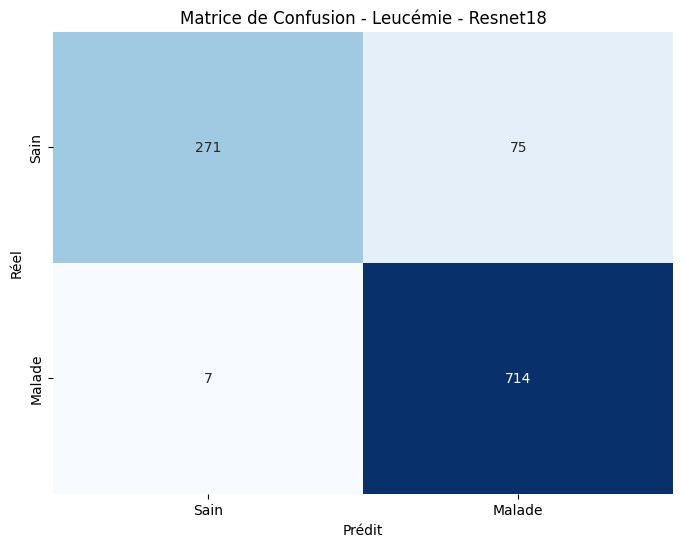

In [16]:
conf_matrix = test_model(model_resnet18, test_dataloader, config.device)

plot_confusion_matrix(conf_matrix, 'Resnet18')